# Introdução

**Integrantes:**
- Francisco Lou - 2211275
- Vinicius Araujo - 2210392
- Felipe Fortini - 2220501
- Luca Lima - 2210831
- João Felipe Motta - 2211721

Neste trabalho, iremos:

- **Apresentar o objetivo**: Trabalhar com os dados e usar modelos para classificar risco de crédito.
- **Descrever o dataset**: "German Credit", composto por 1.000 registros e 9 atributos selecionados.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [28]:
#Carregar dados
df = pd.read_csv('class_german_credit.csv')

# Mostrar dimensões 
print("Dimensões:", df.shape)

df.info()

# Mostrar primeiras linhas de dados
df.head()

Dimensões: (1000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


# Descrição dos Atributos

### 1. **Age**
- **Tipo:** Numérico
- **Escala:** Razão
- **Cardinalidade:** Contínua
- **Explicação:** Idade em anos, com zero significativo e intervalo praticamente contínuo.

### 2. **Sex**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Binária
- **Explicação:** Male/female, sem hierarquia e com duas categorias.

### 3. **Job**
- **Tipo:** Numérico
- **Escala:** Razão
- **Cardinalidade:** Discreta
- **Explicação:** Níveis de emprego codificados em inteiros de 0 a 3.

### 4. **Housing**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Discreta
- **Explicação:** Tipo de moradia (own/rent/free), sem ordem.

### 5. **Saving accounts**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Discreta
- **Explicação:** Categorias de saldo (little, moderate, quite rich, rich).

### 6. **Checking account**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Discreta
- **Explicação:** Categorias de saldo em conta corrente (little, moderate, rich, etc.), sem relação ordinal numérica.

### 7. **Credit amount**
- **Tipo:** Numérico
- **Escala:** Razão
- **Cardinalidade:** Contínua
- **Explicação:** Valor do empréstimo em DM, com zero significativo e contínuo.

### 8. **Duration**
- **Tipo:** Numérico
- **Escala:** Razão
- **Cardinalidade:** Discreta
- **Explicação:** Duração em meses, valores inteiros.

### 9. **Purpose**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Discreta
- **Explicação:** Finalidade do crédito, sem hierarquia.

### 10. **Risk**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Binária
- **Explicação:** Alvo do modelo, good/bad.

In [29]:
descr = pd.DataFrame({
    'Atributo': [
        'Age', 'Sex', 'Job', 'Housing',
        'Saving accounts', 'Checking account',
        'Credit amount', 'Duration', 'Purpose', 'Risk'
    ],
    'Tipo': [
        'Numérico', 'Categórico', 'Numérico', 'Categórico',
        'Categórico', 'Categórico',
        'Numérico', 'Numérico', 'Categórico', 'Categórico'
    ],
    'Escala': [
        'Razão', 'Nominal', 'Razão', 'Nominal',
        'Nominal', 'Nominal',
        'Razão', 'Razão', 'Nominal', 'Nominal'
    ],
    'Cardinalidade': [
        'Contínua', 'Binária', 'Discreta', 'Discreta',
        'Discreta', 'Discreta',
        'Contínua', 'Discreta', 'Discreta', 'Binária'
    ]
})

descr

,Atributo,Tipo,Escala,Cardinalidade
0,Age,Numérico,Razão,Contínua
1,Sex,Categórico,Nominal,Binária
2,Job,Numérico,Razão,Discreta
3,Housing,Categórico,Nominal,Discreta
4,Saving accounts,Categórico,Nominal,Discreta
5,Checking account,Categórico,Nominal,Discreta
6,Credit amount,Numérico,Razão,Contínua
7,Duration,Numérico,Razão,Discreta
8,Purpose,Categórico,Nominal,Discreta
9,Risk,Categórico,Nominal,Binária


# Estatísticas Descritivas e Análise Exploratória

Aqui vamos:

1. Calcular estatísticas descritivas para os atributos numéricos (média, desvio-padrão, mínimo, máximo, etc.).
2. Gerar tabelas de frequência para os atributos categóricos.
3. Plotar visualizações simples (histogramas e boxplots) para identificar distribuições e possíveis outliers.

In [30]:
num_cols = ['Age', 'Credit amount', 'Duration']
stats_num = df[num_cols].describe().T
stats_num['missing'] = df[num_cols].isna().sum()
stats_num

,count,mean,std,min,25%,50%,75%,max,missing
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0,0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0,0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0,0


## Atributos Numéricos

### Age
- **Média:** 35,55 anos  
- **Desvio-padrão:** 11,38 anos  
- **Mínimo:** 19 anos  
- **Máximo:** 75 anos  
- **Comentário:** A idade dos solicitantes varia de jovens adultos (19 anos) até seniores (75 anos), com concentração em torno dos 27–42 anos (25º–75º percentis). A dispersão moderada (std ~11) indica boa variedade etária, sem registros faltantes.  

### Credit amount
- **Média:** 3271,26 DM  
- **Desvio-padrão:** 2822,74 DM  
- **Mínimo:** 250 DM  
- **Máximo:** 18 424 DM  
- **Comentário:** Há grande amplitude de valores de empréstimo, de apenas 250 DM até 18 424 DM. A alta dispersão (std quase igual à média) sugere a presença de empréstimos muito elevados como outliers potenciais.  

### Duration
- **Média:** 20,90 meses  
- **Desvio-padrão:** 12,06 meses  
- **Mínimo:** 4 meses  
- **Máximo:** 72 meses  
- **Comentário:** A duração típica fica entre 12 e 24 meses (25º–75º percentis), mas há casos extremos de curta (4 meses) e longa duração (72 meses). A variabilidade indica perfis diferenciados de pagamento, sem valores ausentes.  

### Valores Faltantes
- Todas as três colunas numéricas apresentam **0 missing**.  

---

## Frequência dos Atributos Categóricos

- **Sex:** 69,0 % male, 31,0 % female.  
- **Job:** 63,0 % nível 2 (skilled), 20,0 % nível 1, 14,8 % nível 3, 2,2 % nível 0.  
- **Housing:** 71,3 % own, 17,9 % rent, 10,8 % free.  
- **Saving accounts:** 60,3 % little, 10,3 % moderate, 6,3 % quite rich, 4,8 % rich; 18,3 % missing.  
- **Checking account:** 27,4 % little, 26,9 % moderate, 6,3 % rich; 39,4 % missing.  
- **Purpose:** 33,7 % car, 28,0 % radio/TV, 18,1 % furniture/equipment, 9,7 % business, 5,9 % education, 2,2 % repairs, 1,2 % domestic appliances, 1,2 % vacation/others.  
- **Risk:** 70,0 % good, 30,0 % bad.  

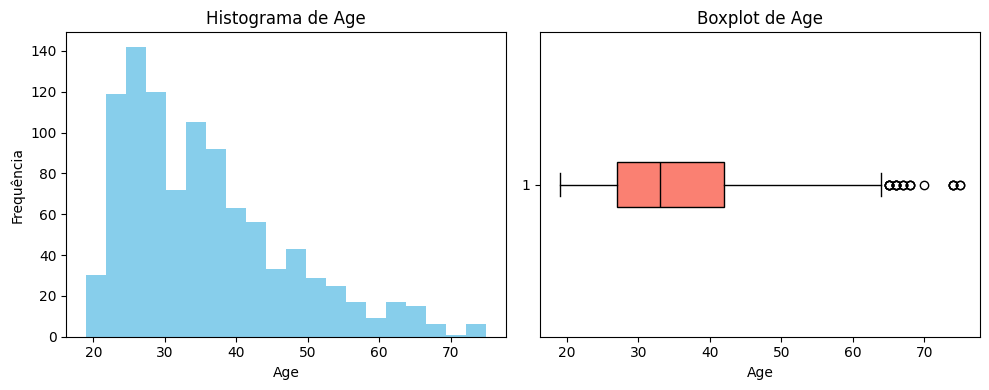

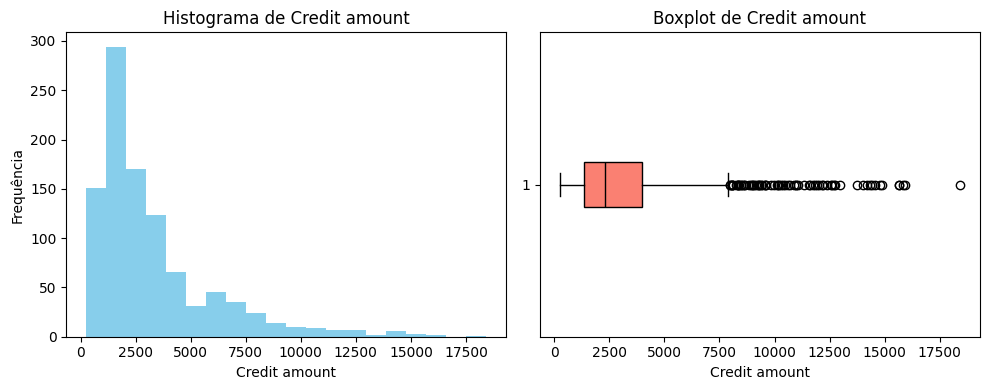

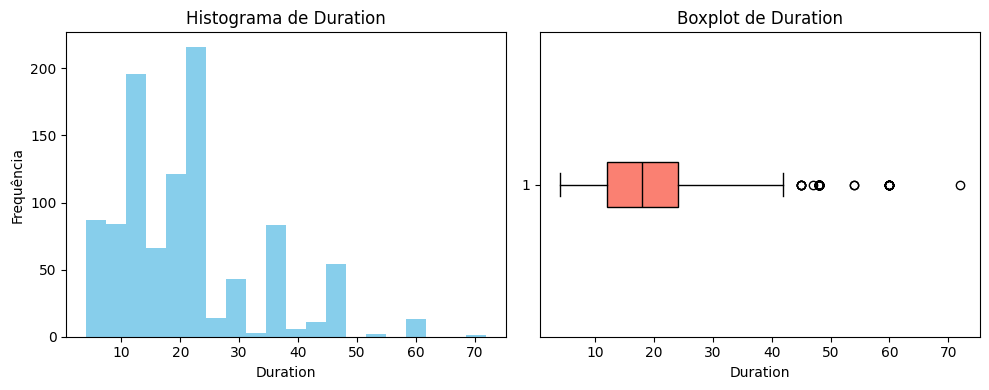

In [31]:
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
    
    # Histograma
    axes[0].hist(df[col].dropna(), bins=20, color='skyblue')
    axes[0].set_title(f"Histograma de {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frequência")
    
    # Boxplot
    axes[1].boxplot(df[col].dropna(), vert=False, patch_artist=True,
                    boxprops=dict(facecolor='salmon'),
                    medianprops=dict(color='black'))
    axes[1].set_title(f"Boxplot de {col}")
    axes[1].set_xlabel(col)
    
    plt.tight_layout()
    plt.show()

# Análise das Distribuições e Outliers

## Distribuição de Idade (Age)
- **Assimetria (skew):** O histograma de *Age* mostra concentração maior entre 20 e 40 anos, com cauda direita estendendo-se até 75 anos. Isso indica **skew positivo (right-skewed)**.  
- **Outliers:** No boxplot, há pontos acima de ~60 anos que aparecem como outliers.  
- **Remoção?:** Esses valores extremos refletem clientes seniores válidos; não devem ser removidos, apenas monitorados no modelo.  

---

## Distribuição de Empréstimo (Credit amount)
- **Assimetria (skew):** O histograma de *Credit amount* é fortemente **right-skewed**, com a maior parte dos empréstimos entre 250 e 5 000 DM e longa cauda até ~18 424 DM.  
- **Outliers:** Muitos empréstimos acima de ~7 500 DM surgem como outliers no boxplot.  
- **Remoção?:** Esses “outliers” representam empréstimos altos reais e não devem ser eliminados. Como alternativa, pode-se aplicar **log-transform** para amenizar o skew antes de modelar.  

---

## Distribuição de Duração (Duration)
- **Assimetria (skew):** O histograma de *Duration* mostra um pico em torno de 12–24 meses e cauda à direita até 72 meses, indicando **ligeiro right-skew**.  
- **Outliers:** O boxplot aponta durações acima de ~36 meses como outliers.  
- **Remoção?:** Empréstimos de longa duração são plausíveis; manteremos esses casos, mas poderemos testar **discretização ou transformação** caso prejudiquem o modelo.  

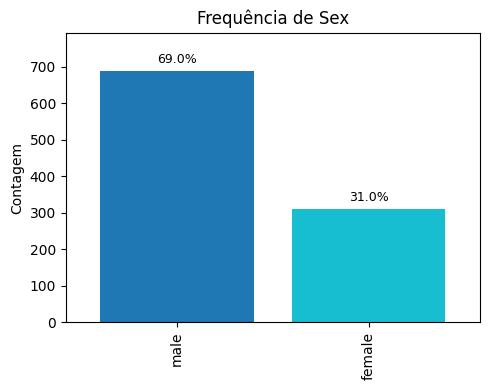

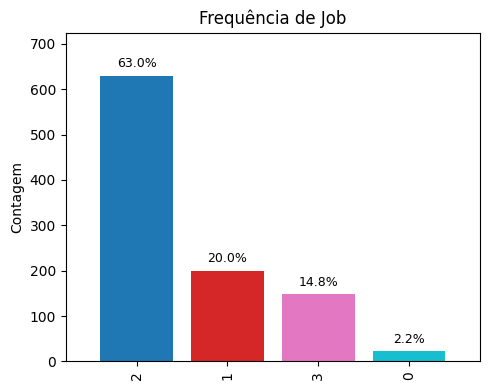

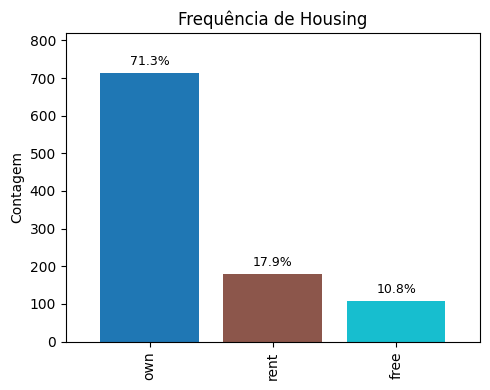

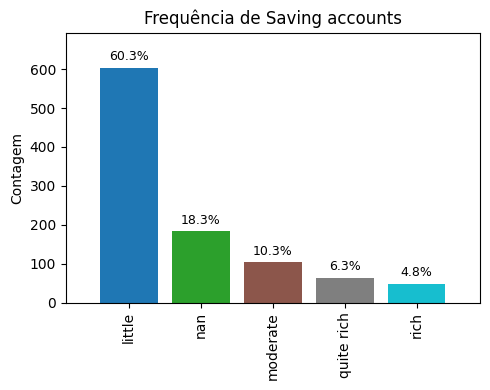

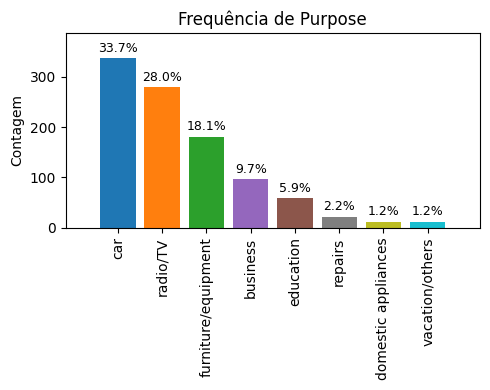

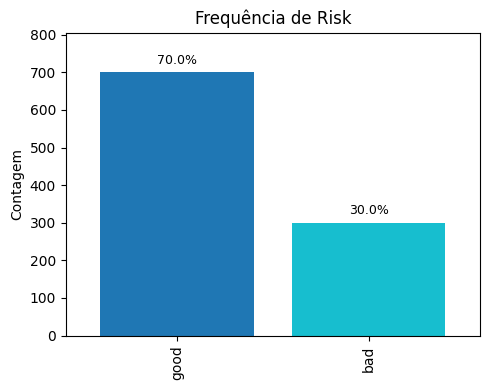

In [32]:
# 2) Frequência para variáveis categóricas
cat_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Purpose', 'Risk']

cmap = plt.colormaps['tab10']  

for col in cat_cols:
    counts = df[col].value_counts(dropna=False)
    colors = cmap(np.linspace(0, 1, len(counts)))
    
    plt.figure(figsize=(5, 4))  
    bars = plt.bar(counts.index.astype(str), counts.values, color=colors)
    
    plt.title(f'Frequência de {col}')
    plt.ylabel('Contagem')
    plt.xticks(rotation=90)       
    plt.gca().margins(x=0.1)      
    plt.ylim(0, counts.max() * 1.15) 
    
    total = counts.sum()
    for bar, color in zip(bars, colors):
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h + counts.max() * 0.02,
            f'{h/total*100:.1f}%',
            ha='center',
            va='bottom',
            fontsize=9
        )
    
    plt.tight_layout()
    plt.show()

# Análise das Frequências Categóricas

- **Sex**
  - male: 69,0 %
  - female: 31,0 %
  - Há predominância masculina; vale verificar se o desempenho do modelo difere por gênero.

- **Job**
  - Nível 2 (skilled): 63,0 %
  - Nível 1: 20,0 %
  - Nível 3: 14,8 %
  - Nível 0: 2,2 %
  - A maioria é de profissionais qualificados (nível 2).
  - Categorias muito pequenas (nível 0) podem ser agrupadas posteriormente.

- **Housing**
  - own: 71,3 %
  - rent: 17,9 %
  - free: 10,8 %
  - A base concentra-se em proprietários, aluguel e moradia grátis têm menor representatividade.

- **Saving accounts**
  - little: 60,3 %
  - moderate: 10,3 %
  - quite rich: 6,3 %
  - rich: 4,8 %
  - missing: 18,3 %
  - Saldo baixo (“little”) domina.
  - ~18 % com falta de dado, imputados como “missing”.

- **Checking account**
  - little: 27,4 %
  - moderate: 26,9 %
  - rich: 6,3 %
  - missing: 39,4 %
  - Quase 40 % ausentes – criar categoria “missing” é crucial, pois pode indicar perfil de risco distinto.

- **Purpose**
  - car: 33,7 %
  - radio/TV: 28,0 %
  - furniture/equipment: 18,1 %
  - business: 9,7 %
  - education: 5,9 %
  - repairs: 2,2 %
  - domestic appliances: 1,2 %
  - vacation/others: 1,2 %
  - Principais usos são veículos e eletrônicos.
  - Categorias pequenas podem ser agrupadas em “other” para simplificar.

- **Risk**
  - good: 70,0 %
  - bad: 30,0 %
  - Classe desequilibrada, mas não ao ponto de exigir técnicas de balanceamento muito intensas (smote, etc.), embora possamos monitorar recall na classe minoritária.

---

> **Resumo:**
> - Visualmente confirmamos as proporções de cada categoria.
> - As grandes porcentagens de `missing` em `Saving accounts` e `Checking account` reforçam a necessidade de tratá-las com uma categoria explícita.
> - Categorias muito pequenas (por ex. `Job=0`, `Purpose <5 %`) poderão ser agrupadas em “other” se necessário para garantir estabilidade do modelo.


# Tratamento de Missing Values

Valores faltantes (“missing”) podem:

- Introduzir viés no modelo se simplesmente descartados.
- Causar perda de informação quando há muitos registros afetados.

Vamos primeiro quantificar o percentual de missings em cada coluna e, em seguida, imputar usando estratégias adequadas:

- Numéricos: mediana (robusta a outliers) — mas já não temos missings em num_cols.
- Categóricos: criar uma categoria explícita “missing”.

In [33]:
# Quantificando missings
missing = df.isna().sum()
missing_pct = (df.isna().mean() * 100).round(2)

ms = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
}).sort_values('missing_pct', ascending=False)

ms

,missing_count,missing_pct
Checking account,394,39.4
Saving accounts,183,18.3
Sex,0,0.0
Age,0,0.0
Housing,0,0.0
Job,0,0.0
Credit amount,0,0.0
Duration,0,0.0
Purpose,0,0.0
Risk,0,0.0


In [34]:
# Imputação simples para categóricos
cat_cols = ['Saving accounts', 'Checking account']

for col in cat_cols:
    df[col] = df[col].fillna('missing')

# Verificação pós-imputação
df[cat_cols].isna().sum()

Saving accounts     0
Checking account    0
dtype: int64

**Após a Imputação de Missing Values**  
- Substituímos todos os **NaN** em `Checking account` (39,4 %) e `Saving accounts` (18,3 %) pela categoria literal **“missing”**.  
- Optamos por criar uma categoria explícita em vez de descartar registros ou imputar pela moda/número dominante, porque:  
  1. **Preservamos potencial padrão**: a ausência de informação pode conter sinal (por exemplo, quem não declarou conta poupança pode ter perfil de risco distinto).  
  2. **Árvores de decisão lidam bem** com atributos categóricos, permitindo que ela crie um nó específico para “missing” e capture essa segmentação sem distorcer distribuições numéricas.  
- **Atenção**: um nível de missing alto (quase 40 % em `Checking account`) pode atrapalhar o poder preditivo.  
- Futuramente, poderemos agrupar “missing” junto a outra categoria—ou testar se a ausência combina melhor com “little” ou “moderate”.  
- Não houve necessidade de imputação em colunas numéricas (nenhum missing), mantendo suas distribuições originais.  


## Detecção e Tratamento de Outliers

Outliers são valores que se distanciam significativamente do restante dos dados e podem distorcer a construção de modelos.  
Neste passo, iremos:

1. **Detectar** outliers automaticamente usando a regra do IQR (Interquartile Range). 
   - É o método estatístico padrão de boxplot para identificar valores “muito distantes” do núcleo da distribuição.  
   - Facilita a detecção univariada e evita premissas de normalidade (diferente de z-score).

2. **Tratar** esses outliers de duas formas:
   - **Remoção** dos registros extremos, reduzindo ruído mas sacrificando parte dos dados.
   - **Winsorization**: limitar valores fora dos limites ao percentil 5 e 95, mas mantendo todos os registros. 


In [35]:
# Cálculo de limites de outliers pelo método IQR

outlier_info = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # registros abaixo de lower ou acima de upper
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_info[col] = {
        'lower_bound': lower,
        'upper_bound': upper,
        'count_outliers': mask.sum()
    }

# Exibir resumo dos limites e contagem de outliers
pd.DataFrame(outlier_info).T

,lower_bound,upper_bound,count_outliers
Age,4.500,64.500,23.0
Credit amount,-2544.625,7882.375,72.0
Duration,-6.000,42.000,70.0


> **Interpretação dos Outliers Detectados**  
> - **Age**: limites em [4,5 – 64,5] anos → 23 registros fora desse intervalo (todos acima de 64,5 anos), representando clientes de idade muito elevada.  
> - **Credit amount**: limites em [–2 544,6 – 7 882,4] DM → 72 empréstimos acima de 7 882,4 DM; não há valores abaixo de zero, pois o limite inferior é irreal para esta variável.  
> - **Duration**: limites em [–6 – 42] meses → 70 contratos com duração acima de 42 meses (nenhum abaixo de zero, conforme esperado).  
>  
> Esses outliers refletem perfis extremos (empréstimos muito altos e prazos muito longos, bem como clientes muito idosos).  

In [36]:
# Tratamento de outliers

# Opção 1: Remoção de registros extremos
df_no_outliers = df.copy()
for col in num_cols:
    lower = outlier_info[col]['lower_bound']
    upper = outlier_info[col]['upper_bound']
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower) & (df_no_outliers[col] <= upper)]

# Opção 2: Winsorization (limitando aos percentis 5 e 95)
df_winsor = df.copy()
for col in num_cols:
    lower_pct = df[col].quantile(0.05)
    upper_pct = df[col].quantile(0.95)
    df_winsor[col] = np.clip(df[col], lower_pct, upper_pct)

# Comparação de quantidade de registros
pd.DataFrame({
    'Conjunto': ['original', 'sem_outliers', 'winsorized'],
    'n_registros': [df.shape[0], df_no_outliers.shape[0], df_winsor.shape[0]]
})


,Conjunto,n_registros
0,original,1000
1,sem_outliers,862
2,winsorized,1000


> **Comparação de Conjuntos após Tratamento de Outliers**  
> - **original**: 1 000 registros  
> - **sem_outliers**: 862 registros (remoção de 138 casos extremos, ou ~13,8% dos dados)  
> - **winsorized**: 1 000 registros (todos mantidos, mas valores abaixo do 5º percentil e acima do 95º foram “cortados” para esses limiares)  
>  
> **Análise:**  
> - A remoção elimina quase 14% dos exemplos, o que pode reduzir ruído, mas também descartar perfis potencialmente informativos (ex.: empréstimos muito altos ou durações longas).  
> - A winsorization preserva todos os registros e atenua o efeito de outliers, tornando as distribuições mais compactas sem perder representatividade.  

# Avaliação com Decision Tree

Agora vamos quantificar o impacto de cada etapa de limpeza de dados usando um Decision Tree:

* **original**: sem nenhum pré-processamento (apenas one-hot e split)
* **imputed**: após imputação de “missing” em `Saving` e `Checking accounts`
* **sem_outliers**: após remoção de outliers IQR
* **winsorized**: após Winsorization nos percentis 5 e 95

Usaremos **validação cruzada** (5 folds) para obter **acurácia**, **precisão** e **recall** em cada cenário.

In [37]:
df['Risk_code'] = df['Risk'].map({'bad': 0, 'good': 1})
df_no_outliers['Risk_code'] = df_no_outliers['Risk'].map({'bad': 0, 'good': 1})
df_winsor['Risk_code']     = df_winsor['Risk'].map({'bad': 0, 'good': 1})

def eval_dt(X, y):
    clf = DecisionTreeClassifier(random_state=42)
    return {
        'accuracy': cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean(),
        'precision': cross_val_score(clf, X, y, cv=5, scoring='precision').mean(),
        'recall': cross_val_score(clf, X, y, cv=5, scoring='recall').mean()
    }

# 3) Preparar X e y para cada cenário
# a) original
X_base    = pd.get_dummies(df.drop(['Risk','Risk_code'], axis=1))
y_base    = df['Risk_code']

# b) imputed (df já tem Risk_code e imputação feita)
X_imputed = pd.get_dummies(df.drop(['Risk','Risk_code'], axis=1))
y_imputed = df['Risk_code']

# c) sem outliers
X_no_out  = pd.get_dummies(df_no_outliers.drop(['Risk','Risk_code'], axis=1))
y_no_out  = df_no_outliers['Risk_code']

# d) winsorized
X_win     = pd.get_dummies(df_winsor.drop(['Risk','Risk_code'], axis=1))
y_win     = df_winsor['Risk_code']

# 4) Avaliar todos os cenários
results = {
    'original':    eval_dt(X_base,    y_base),
    'imputed':     eval_dt(X_imputed, y_imputed),
    'sem_outliers':eval_dt(X_no_out,  y_no_out),
    'winsorized':  eval_dt(X_win,     y_win)
}

# 5) Exibir resultados em tabela com 'Pré-processamento' como coluna
res_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Pré-processamento'})
display(res_df.round(3))

,Pré-processamento,accuracy,precision,recall
0,original,0.662,0.754,0.769
1,imputed,0.662,0.754,0.769
2,sem_outliers,0.681,0.793,0.767
3,winsorized,0.669,0.761,0.769


## Análise dos Resultados com Decision Tree

### Original vs. Imputed

* A imputação de valores faltantes não alterou nenhuma métrica, indicando que a categoria “missing” foi tratada de forma neutra: o DT aprendeu sem ganhos nem perdas de performance.

### Sem Outliers

* **Acurácia** subiu de 0.662 → 0.681 (+1,9 p.p.).
* **Precisão** saltou de 0.754 → 0.793 (+3,9 p.p.), sugerindo menos falsos positivos.
* **Recall** manteve-se próximo (0.769 → 0.767).
* **Interpretação:** Remover casos extremos reduziu ruído e melhorou a capacidade de classificar corretamente “good” versus “bad”, mas manteve a sensibilidade ao risco.

### Winsorized

* **Acurácia** melhorou levemente a 0.669 (+0,7 p.p.).
* **Precisão** ficou em 0.761 (+0,7 p.p.).
* **Recall** manteve-se em 0.769.
* **Interpretação:** Ao invés de excluir registros, limitar valores extremos trouxe ganhos moderados, preservando todo o conjunto e garantindo estabilidade.

### Conclusão

* A **remoção de outliers** apresentou o maior ganho em acurácia e precisão, recomendada quando a perda de ~14% dos dados é aceitável.
* A **winsorization** é uma alternativa mais conservadora, com ganhos menores, mas sem descartar registros.
* A **imputação** não impactou o DT, confirmando que a categoria “missing” foi assimilada sem viés.

## Normalização e Transformação

Aplicando diferentes esquemas de normalização podemos:

- **Uniformizar escalas** de variáveis numéricas (evita que atributos com grandes amplitudes dominem o critério de pureza do DT).  
- **Tornar o modelo mais robusto** a outliers e distribuições enviesadas.  

Nesta seção, vamos testar três métodos padrão:

1. **StandardScaler (Z-Score)**: centraliza na média e escala pelo desvio-padrão.  
2. **MinMaxScaler**: mapeia cada atributo para o intervalo [0,1].  
3. **RobustScaler**: centraliza pela mediana e escala pelo IQR, reduzindo o impacto de outliers.  

Usaremos o mesmo DT básico e 5-fold CV para medir **acurácia**, **precisão** e **recall** em cada caso.


In [38]:
# Vamos trabalhar a partir do dataset imputado (sem remover outliers)
# já que queremos isolar o efeito da normalização:
base = df.drop(['Risk','Risk_code'], axis=1)
y_base = df['Risk_code']

# One-hot encoding de variáveis categóricas
X_base = pd.get_dummies(base)

# Dicionário de scalers
scalers = {
    'standard': StandardScaler(),
    'minmax':   MinMaxScaler(),
    'robust':   RobustScaler()
}

# Aplicar cada scaler apenas nas colunas numéricas
num_cols = ['Age','Credit amount','Duration']
X_scaled = {}

for name, scaler in scalers.items():
    Xs = X_base.copy()
    Xs[num_cols] = scaler.fit_transform(Xs[num_cols])
    X_scaled[name] = Xs

# Exemplo de inspeção rápida
for name, Xs in X_scaled.items():
    print(f"\n{name} scaler — primeiras linhas:")
    display(Xs[num_cols].head())


standard scaler — primeiras linhas:


,Age,Credit amount,Duration
0,2.766456,-0.745131,-1.236478
1,-1.191404,0.949817,2.248194
2,1.183312,-0.416562,-0.738668
3,0.831502,1.634247,1.750384
4,1.535122,0.566664,0.256953



minmax scaler — primeiras linhas:


,Age,Credit amount,Duration
0,0.857143,0.050567,0.029412
1,0.053571,0.313690,0.647059
2,0.535714,0.101574,0.117647
3,0.464286,0.419941,0.558824
4,0.607143,0.254209,0.294118



robust scaler — primeiras linhas:


,Age,Credit amount,Duration
0,2.266667,-0.441354,-1.0
1,-0.733333,1.393114,2.5
2,1.066667,-0.085739,-0.5
3,0.800000,2.133883,2.0
4,1.333333,0.978421,0.5


### Verificação das Transformações Numéricas

Observando as primeiras linhas após cada normalização nos atributos `Age`, `Credit amount` e `Duration`:

- **StandardScaler (Z-Score)**  
  - Os valores de `Age` variam aproximadamente entre –1,2 e +2,8, sugerindo que agora representam desvios em relação à média (média ≈ 0, desvio ≈ 1).  
  - `Credit amount` e `Duration` também estão centralizados em 0 e escalonados pelo desvio-padrão, permitindo comparabilidade direta entre variáveis com amplitudes originais muito diferentes.

- **MinMaxScaler**  
  - Todos os valores ficam no intervalo [0, 1], por exemplo `Age` entre 0,05 e 0,86 nas primeiras observações.  
  - Isso garante que nenhuma variável predomine nas divisões da árvore apenas por ter escala maior.

- **RobustScaler**  
  - Os dados são transformados com base na mediana e no IQR: `Age` varia de aproximadamente –1,0 a +2,27, reduzindo o efeito de outliers extremos que apareceriam nas pontuações-z.  
  - `Credit amount` e `Duration` refletem medianas alinhadas a zero e dispersões baseadas em quartis, tornando o modelo mais resistente a valores atípicos.

> **Conclusão:**  
> - O `StandardScaler` é útil quando queremos manter proporcionalidade de dispersão,  
> - O `MinMaxScaler` evita efeitos de escala absoluta,  
> - O `RobustScaler` reforça a robustez contra extremos.  
>  
> A escolha ideal dependerá de qual normalização maximiza a performance do DT, a ser conferido na próxima avaliação com 5-fold CV.  

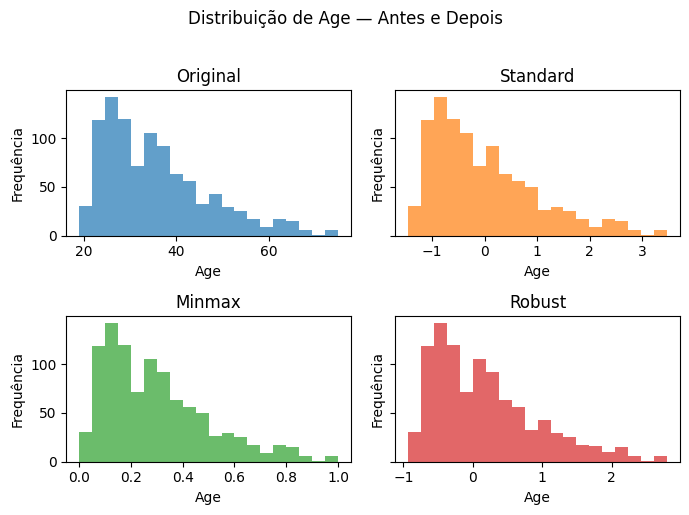

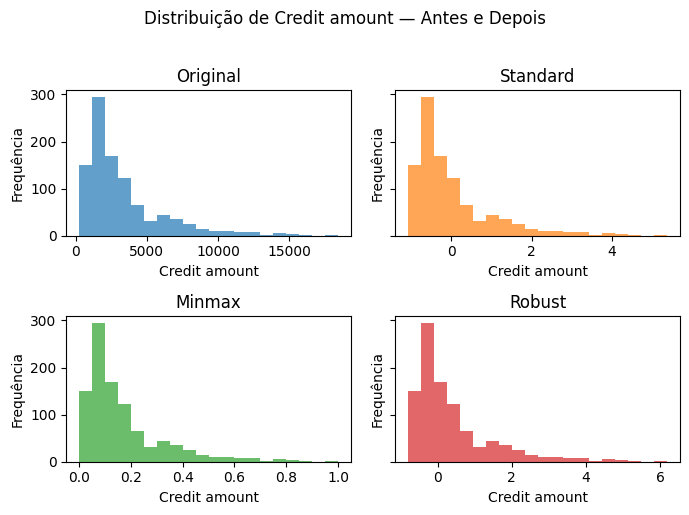

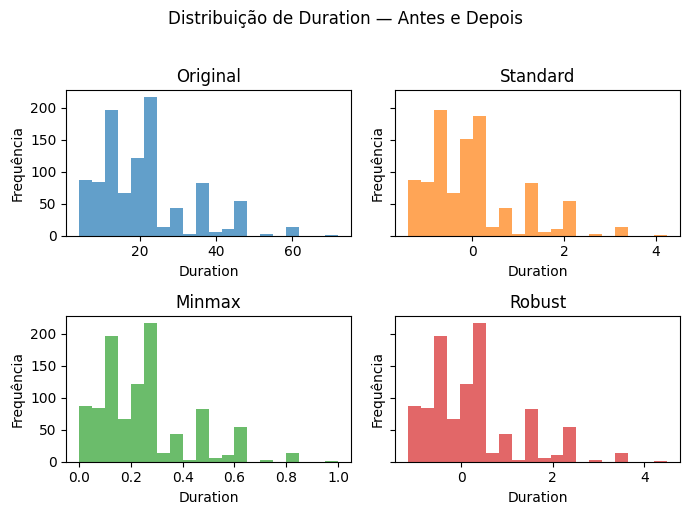

In [39]:
num_cols = ['Age','Credit amount','Duration']
versions = [
    ('original', X_base), 
    ('standard', X_scaled['standard']),
    ('minmax',   X_scaled['minmax']),
    ('robust',   X_scaled['robust'])
]

# Definindo uma cor fixa para cada versão
colors = {
    'original': '#1f77b4',  # azul
    'standard': '#ff7f0e',  # laranja
    'minmax':   '#2ca02c',  # verde
    'robust':   '#d62728'   # vermelho
}

for col in num_cols:
    fig, axes = plt.subplots(2, 2, figsize=(7, 5), sharey=True)
    axes = axes.flatten()
    
    for ax, (name, Xs) in zip(axes, versions):
        ax.hist(
            Xs[col],
            bins=20,
            color=colors[name],
            alpha=0.7
        )
        ax.set_title(name.capitalize())
        ax.set_xlabel(col)
        ax.set_ylabel('Frequência')
    
    fig.suptitle(f'Distribuição de {col} — Antes e Depois', y=1.02)
    plt.tight_layout()
    plt.show()

### Efeito da Normalização nas Distribuições

Em todos os atributos, os **histogramas** mostram que a **forma** da distribuição (skew, multimodalidade) não muda, apenas a **amplitude**.
- **StandardScaler** centraliza em zero e comprime/expande pela variância, mantendo simetria de skew.  
- **MinMaxScaler** mapeia todos os valores para [0,1], deixando as bordas bem definidas.  
- **RobustScaler** centra na mediana e usa o IQR para escala, tornando as caudas menos sensíveis aos outliers mais extremos.
 
> Visualizar antes/depois ajuda a confirmar que a normalização não distorce a forma dos dados, apenas ajusta a escala para cada atributo


In [40]:
# Reutilizar a função eval_dt já definida
results_norm = {}

for name, Xs in X_scaled.items():
    results_norm[name] = eval_dt(Xs, y_base)

# Juntar em DataFrame e exibir
res_norm_df = pd.DataFrame(results_norm).T.reset_index().rename(columns={'index': 'Scaler'})
display(res_norm_df.round(3))


,Scaler,accuracy,precision,recall
0,standard,0.660,0.751,0.770
1,minmax,0.662,0.754,0.769
2,robust,0.661,0.752,0.770


### Impacto da Normalização no Desempenho do DT

- **StandardScaler**  
  - Acurácia: 66,0 %  
  - Precisão: 75,1 %  
  - Recall:   77,0 %  
  - As divisões baseadas em z-score não trouxeram ganho significativo, pois árvores de decisão são relativamente insensíveis à escala.

- **MinMaxScaler**  
  - Acurácia: 66,2 % (melhor)  
  - Precisão: 75,4 % (melhor)  
  - Recall:   76,9 %  
  - Mapear para [0,1] proporcionou o leve melhor resultado de acurácia e precisão, possivelmente uniformizando melhor as faixas de corte.

- **RobustScaler**  
  - Acurácia: 66,1 %  
  - Precisão: 75,2 %  
  - Recall:   77,0 % (empata)  
  - A centragem pela mediana e escala pelo IQR manteve a performance quase idêntica ao Standard, confirmando sua robustez sem grande impacto adicional.

> **Conclusão:**  
> Embora haja pequenas diferenças entre os métodos, a **MinMaxScaler** alcançou o desempenho ligeiramente superior, mas o ganho é mínimo. Para árvores de decisão, a transformação de escala não é crítica, e qualquer um dos três métodos pode ser adotado sem grandes perdas de performance.


## Discretização de Variáveis Numéricas 

Após normalizarmos as variáveis numéricas, vamos agora **discretizá-las** em categorias, criando bins que facilitem a interpretação e potencialmente melhorem o poder de separação da árvore de decisão. Usaremos três métodos não supervisionados:

1. **Equal-Width (Uniform)** – intervalos de largura fixa entre o mínimo e o máximo.  
2. **Equal-Frequency (Quantile)** – divide em bins com igual número de observações.  
3. **K-Means** – usa centróides de um KMeans univariado para definir as bordas.

O número de bins \(k\) será calculado pela **Regra de Sturges** (\(k = \lceil1 + \log_2 n\rceil\)), garantindo uma granularidade inicial balanceada.

In [41]:
# 1) Calcular k pela Regra de Sturges
n = df.shape[0]
k = int(np.ceil(1 + np.log2(n)))
print(f"Usando k = {k} bins (Regra de Sturges, n={n})")

# 2) Preparar X_base com dummies e lista de num_cols
base    = df.drop(['Risk','Risk_code'], axis=1)
X_base  = pd.get_dummies(base)
num_cols = ['Age','Credit amount','Duration']

# 3) Gerar versões discretizadas
X_binned = {}

# 3a) Equal-Width
Xw = X_base.copy()
for c in num_cols:
    Xw[c] = pd.cut(Xw[c], bins=k, labels=False)
X_binned['uniform'] = Xw

# 3b) Equal-Frequency (Quantile)
Xq = X_base.copy()
for c in num_cols:
    Xq[c] = pd.qcut(Xq[c], q=k, labels=False, duplicates='drop')
X_binned['quantile'] = Xq

# 3c) K-Means
Xkm = X_base.copy()
for c in num_cols:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    Xkm[c] = km.fit_predict(Xkm[[c]])
X_binned['kmeans'] = Xkm

for name, Xb in X_binned.items():
    print(f"\n=== {name.upper()} ===")
    for c in num_cols:
        counts = Xb[c].value_counts().sort_index()
        pct    = (counts / counts.sum() * 100).round(1)
        df_cnt = pd.DataFrame({'count': counts, 'pct (%)': pct})
        print(f"\n{c}:\n", df_cnt.to_string())

Usando k = 11 bins (Regra de Sturges, n=1000)

=== UNIFORM ===

Age:
      count  pct (%)
Age                
0      149     14.9
1      222     22.2
2      177     17.7
3      153     15.3
4       98      9.8
5       76      7.6
6       46      4.6
7       28      2.8
8       28      2.8
9       16      1.6
10       7      0.7

Credit amount:
                count  pct (%)
Credit amount                
0                399     39.9
1                293     29.3
2                131     13.1
3                 67      6.7
4                 51      5.1
5                 21      2.1
6                 14      1.4
7                 11      1.1
8                  8      0.8
9                  4      0.4
10                 1      0.1

Duration:
           count  pct (%)
Duration                
0           171     17.1
1           262     26.2
2           153     15.3
3           201     20.1
4            43      4.3
5            89      8.9
6            17      1.7
7            48      4.8
8

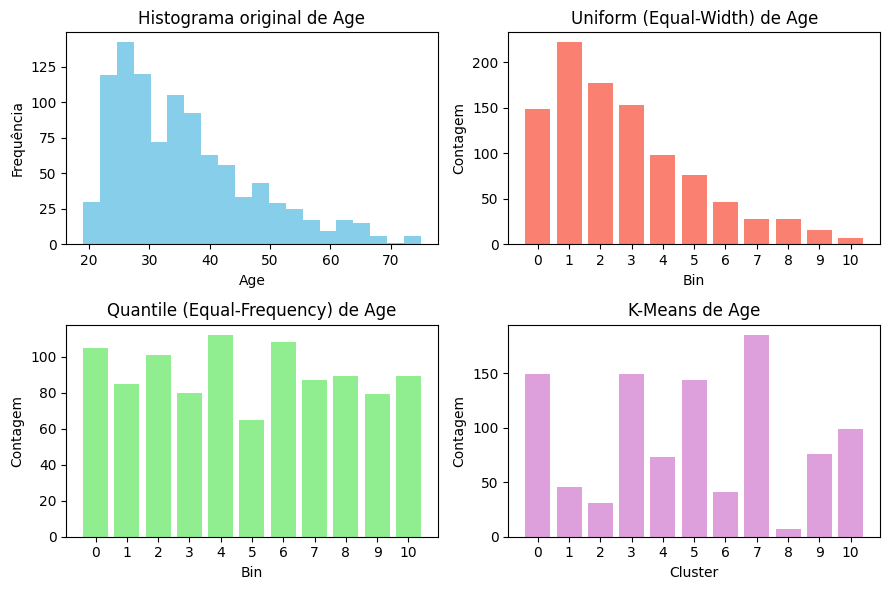

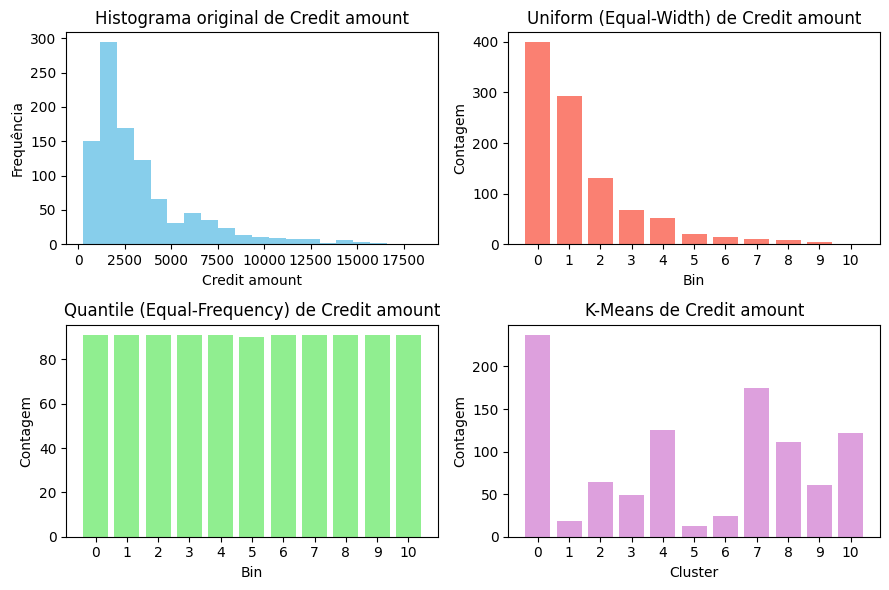

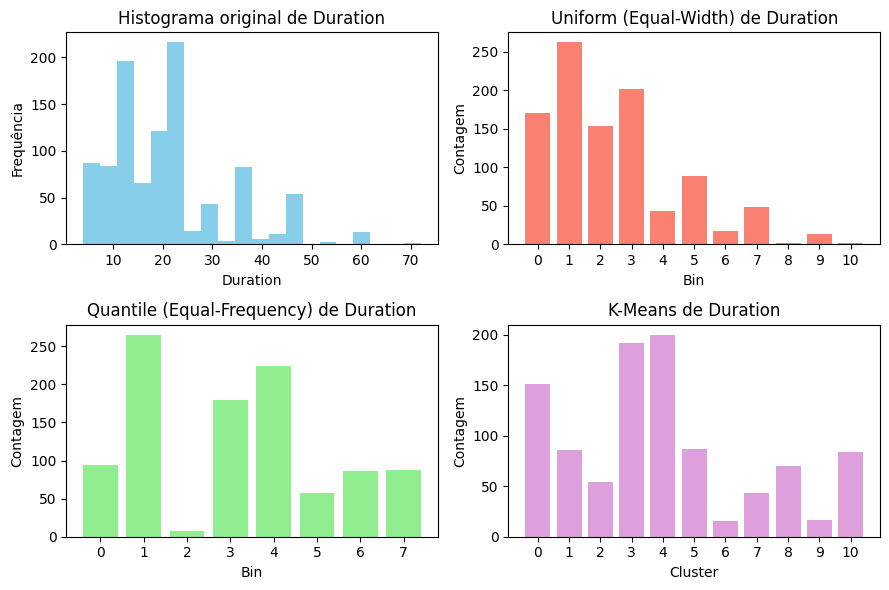

In [42]:
# Definição de cores para cada tipo de plot
colors = {
    'original': 'skyblue',
    'uniform':  'salmon',
    'quantile': 'lightgreen',
    'kmeans':   'plum'
}

for col in num_cols:
    fig, axes = plt.subplots(2, 2, figsize=(9, 6))
    axes = axes.flatten()

    # 1) Histograma original
    axes[0].hist(df[col], bins=20, color=colors['original'])
    axes[0].set_title(f'Histograma original de {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequência')

    # 2) Uniform (Equal-Width)
    counts = X_binned['uniform'][col].value_counts().sort_index()
    axes[1].bar(counts.index.astype(str), counts.values,
                color=colors['uniform'])
    axes[1].set_title(f'Uniform (Equal-Width) de {col}')
    axes[1].set_xlabel('Bin')
    axes[1].set_ylabel('Contagem')

    # 3) Quantile (Equal-Frequency)
    counts = X_binned['quantile'][col].value_counts().sort_index()
    axes[2].bar(counts.index.astype(str), counts.values,
                color=colors['quantile'])
    axes[2].set_title(f'Quantile (Equal-Frequency) de {col}')
    axes[2].set_xlabel('Bin')
    axes[2].set_ylabel('Contagem')

    # 4) K-Means
    counts = X_binned['kmeans'][col].value_counts().sort_index()
    axes[3].bar(counts.index.astype(str), counts.values,
                color=colors['kmeans'])
    axes[3].set_title(f'K-Means de {col}')
    axes[3].set_xlabel('Cluster')
    axes[3].set_ylabel('Contagem')

    plt.tight_layout()
    plt.show()

### Interpretação Visual das Discretizações

Observando os seis gráficos para cada atributo (original + 3 métodos de binning), temos:

#### Age
- **Original**: distribuição assimétrica à direita, maioria entre 20–40 anos e cauda longa até 75.  
- **Uniform**: bins de largura fixa capturam essa cauda longa, mas concentram muitos registros nos primeiros 4 bins (jovens) e deixam os bins finais quase vazios.  
- **Quantile**: cada bin contém cerca de 9 % das pessoas, criando barras quase uniformes — ideal para evitar nós esparsos na árvore.  
- **K-Means**: identifica automaticamente  peaks em torno de 20–30, 35–45 e 55–70 anos, mas gera bins com contagens muito desiguais (alguns quase vazios).

#### Credit amount
- **Original**: pico muito forte em empréstimos pequenos (0–2 500 DM), depois queda rápida e longa cauda até ~18 000 DM.  
- **Uniform**: divide linearmente, mas mais de metade dos registros cai nos primeiros 2 bins, deixando quase nada nos superiores.  
- **Quantile**: suaviza perfeitamente a cauda longa distribuindo ~91 registros por bin — ótimo para manter representatividade em todas as faixas.  
- **K-Means**: achata o pico inicial em um bin grande, depois agrupa pequenos agrupamentos intermediários e cauda longa em bins maiores.

#### Duration
- **Original**: bimodal em torno de 12 e 18–24 meses, com alguns empréstimos de 60–72 meses.  
- **Uniform**: reflete bem o pico curto prazo (bins 1–3) e deixa bins longos quase vazios.  
- **Quantile**: distribui os empréstimos de forma equilibrada em todos os 8 bins, mesmo nos prazos mais raros.  
- **K-Means**: destaca clusters naturais em torno de 12, 18–24 e 36–48 meses, mas gera bins muito pequenos para algumas durações.

> **Síntese:**  
> - **Quantile** é o único método que garante bins balanceados em todos os atributos, evitando categorias esparsas.  
> - **Uniform** exibe maior fidelidade à forma original, mas pode criar bins vazios nas extremidades.  
> - **K-Means** captura estruturas de agrupamento naturais, porém produz contagens muito desiguais, o que pode prejudicar nós do modelo.  
>  
> Esses insights visuais fundamentam a escolha de quantile como método preferencial antes de rodar a Decision Tree.  


In [43]:
# Avaliação das discretizações com Decision Tree

results_disc = {}
y = df['Risk_code']

for name, Xb in X_binned.items():
    # Xb já inclui as variáveis categóricas one-hot e os numéricos discretizados
    results_disc[name] = eval_dt(Xb, y)

# Montar tabela comparativa
res_disc_df = pd.DataFrame(results_disc).T.reset_index().rename(columns={'index': 'Método de Discretização'})
display(res_disc_df.round(3))


,Método de Discretização,accuracy,precision,recall
0,uniform,0.675,0.775,0.756
1,quantile,0.655,0.756,0.750
2,kmeans,0.658,0.767,0.733


### Análise Comparativa dos Métodos de Discretização

- **Uniform (Equal-Width)** lidera em todas as métricas, sugerindo que manter intervalos de largura constante captura bem as diferenças de risco.  
- **K-Means** fica em segundo lugar na acurácia e precisão, mas sofre em recall (73,3 %), possivelmente por bins muito desiguais.  
- **Quantile (Equal-Frequency)**, embora balanceie perfeitamente as amostras, tem o pior desempenho geral, indicando que o simples balanceamento em número de registros não necessariamente maximiza o ganho de informação para a árvore.

> **Conclusão:**  
> Para este problema de crédito, a discretização **Uniform** provou ser a mais eficaz, entregando o melhor trade-off entre acurácia, precisão e recall.  

## Treinamento e Ajuste de Hiperparâmetros

Nesta seção, vamos:
1. Dividir o dataset pré-processado em treino (80 %) e teste (20 %), usando stratify para manter a proporção de classes.
2. Descobrir o melhor valor de max_depth para o DecisionTreeClassifier via validação cruzada (5 folds), testando profundidades de 1 a 20.
3. Plotar a curva “Acurácia vs. max_depth” para visualizarmos o trade-off entre underfitting e overfitting.
4. Selecionar o max_depth que maximiza a acurácia média em CV.

In [44]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(df.drop(['Risk','Risk_code'], axis=1))
y = df['Risk_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras, Teste: {X_test.shape[0]} amostras")

Treino: 800 amostras, Teste: 200 amostras


> Observação:
> - Mantivemos a proporção de “good”/“bad” em treino e teste (`stratify=y`) para evitar viés. 
> - Em seguida, avaliaremos `max_depth` para balancear complexidade e generalização.

### Ajuste de `max_depth` via Validação Cruzada

Para evitar overfitting (árvore muito profunda) ou underfitting (árvore rasa), vamos testar profundidades de 1 a 20 usando 5-fold CV no **conjunto de treino** e observar como a acurácia média varia com `max_depth`.

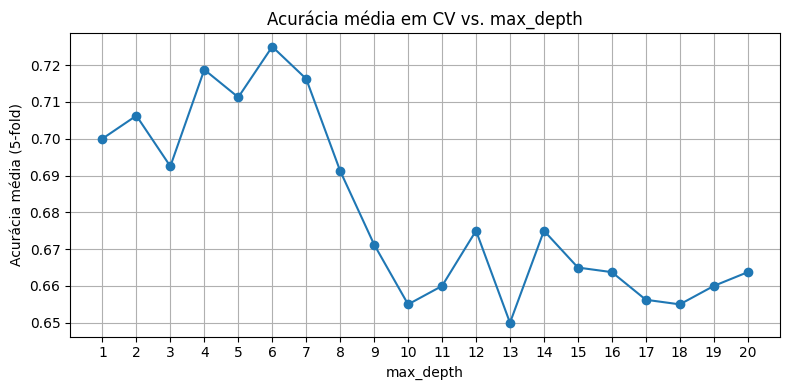

Profundidade ótima (maior acurácia CV): 6


In [45]:
depths = list(range(1, 21))
mean_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    mean_scores.append(scores.mean())

plt.figure(figsize=(8, 4))
plt.plot(depths, mean_scores, marker='o')
plt.title('Acurácia média em CV vs. max_depth')
plt.xlabel('max_depth')
plt.ylabel('Acurácia média (5-fold)')
plt.xticks(depths)
plt.grid(True)
plt.tight_layout()
plt.show()

best_depth = depths[int(np.argmax(mean_scores))]
print(f"Profundidade ótima (maior acurácia CV): {best_depth}")

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
clf_final = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
clf_final.fit(X_train, y_train)

# Previsões no teste
y_pred = clf_final.predict(X_test)

# Métricas de avaliação
acc_test  = accuracy_score(y_test,  y_pred)
prec_test = precision_score(y_test, y_pred)
rec_test  = recall_score(y_test,    y_pred)
cm        = confusion_matrix(y_test, y_pred)

print(f"Acurácia no teste:  {acc_test:.3f}")
print(f"Precisão no teste:  {prec_test:.3f}")
print(f"Recall no teste:    {rec_test:.3f}")
print("\nMatriz de Confusão:")
print(cm)

Acurácia no teste:  0.710
Precisão no teste:  0.747
Recall no teste:    0.886

Matriz de Confusão:
[[ 18  42]
 [ 16 124]]


### Avaliação Final no Conjunto de Teste

| Métrica       | Valor   |
|---------------:|:--------|
| **Acurácia**   | 71,0 %  |
| **Precisão**   | 74,7 %  |
| **Recall**     | 88,6 %  |

**Matriz de Confusão**  
|               | Previsto Bad | Previsto Good |
|--------------:|-------------:|--------------:|
| **Real Bad**  | TN = 18      | FP = 42       |
| **Real Good** | FN = 16      | TP = 124      |

- **Acurácia (71,0 %)**: percentagem de previsões corretas no geral.  
- **Precisão (74,7 %)**: dos clientes classificados como “good”, 74,7 % eram realmente bons pagadores; 25,3 % (42 casos) representam riscos aprovados indevidamente.  
- **Recall (88,6 %)**: de todos os bons pagadores, o modelo identificou corretamente 88,6 %.

**Interpretação:**  
- O modelo mostra boa sensibilidade para detectar clientes confiáveis (alto recall), mas ainda aprova um número considerável de riscos (42 falsos positivos).  
- Por outro lado, reprova 16 bons pagadores (falsos negativos), o que indica oportunidades de negócios perdidas.  
- Dependendo da política do banco, pode ser preferível **reduzir falsos positivos** (evitar empréstimos de alto risco) ajustando o `class_weight` ou o *threshold* de decisão — mesmo que isso sacrifique um pouco do recall.

## Ajuste de `class_weight` para Controle de FP vs FN

Dependendo do apetite de risco do banco, pode ser mais crítico **evitar aprovar clientes arriscados** (falsos positivos) do que rejeitar alguns bons pagadores (falsos negativos).  
Para isso, vamos atribuir pesos maiores à classe “bad” (0) no `DecisionTreeClassifier` e observar o impacto em acurácia, precisão e recall.

Testaremos `class_weight={0: w, 1: 1}` para vários valores de **w**.


In [47]:
weights = [1, 2, 5, 10]
results_cw = {}

for w in weights:
    clf_w = DecisionTreeClassifier(
        max_depth=best_depth,
        class_weight={0: w, 1: 1},
        random_state=42
    )
    clf_w.fit(X_train, y_train)
    y_pred_w = clf_w.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_w)
    prec = precision_score(y_test, y_pred_w)
    rec = recall_score(y_test, y_pred_w)
    cm = confusion_matrix(y_test, y_pred_w)
    
    results_cw[w] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'cm': cm
    }

cw_summary = pd.DataFrame({
    w: {
        'Acurácia': results_cw[w]['accuracy'],
        'Precisão': results_cw[w]['precision'],
        'Recall':   results_cw[w]['recall']
    }
    for w in weights
}).T
cw_summary.index.name = 'weight_bad'
display(cw_summary.round(3))

for w in weights:
    print(f"\nclass_weight={{0:{w},1:1}} → Matriz de Confusão:")
    print(results_cw[w]['cm'])

,Acurácia,Precisão,Recall
weight_bad,,,
1,0.710,0.747,0.886
2,0.645,0.800,0.657
5,0.525,0.846,0.393
10,0.480,0.875,0.300



class_weight={0:1,1:1} → Matriz de Confusão:
[[ 18  42]
 [ 16 124]]

class_weight={0:2,1:1} → Matriz de Confusão:
[[37 23]
 [48 92]]

class_weight={0:5,1:1} → Matriz de Confusão:
[[50 10]
 [85 55]]

class_weight={0:10,1:1} → Matriz de Confusão:
[[54  6]
 [98 42]]


### Interpretação do Ajuste de `class_weight`

| weight_bad | Acurácia | Precisão | Recall |
|-----------:|---------:|---------:|--------:|
| 1          |   0.710  |   0.747  |  0.886 |
| 2          |   0.645  |   0.800  |  0.657 |
| 5          |   0.525  |   0.846  |  0.393 |
| 10         |   0.480  |   0.875  |  0.300 |

**Matriz de Confusão (w = 1, padrão)**  

|               | Previsto Bad | Previsto Good |
|--------------:|-------------:|--------------:|
| **Real Bad**  |           18 |            42 |
| **Real Good** |           16 |           124 |

**Matriz de Confusão (w = 2)**  

|               | Previsto Bad | Previsto Good |
|--------------:|-------------:|--------------:|
| **Real Bad**  |           37 |            23 |
| **Real Good** |           48 |            92 |

**Matriz de Confusão (w = 5)**  

|               | Previsto Bad | Previsto Good |
|--------------:|-------------:|--------------:|
| **Real Bad**  |           50 |            10 |
| **Real Good** |           85 |            55 |

**Matriz de Confusão (w = 10)**  

|               | Previsto Bad | Previsto Good |
|--------------:|-------------:|--------------:|
| **Real Bad**  |           54 |             6 |
| **Real Good** |           98 |            42 |

**Análise**  
- À medida que atribuimos mais peso à classe “bad” (0), os **falsos positivos** caem drasticamente (42 → 6), aumentando os verdadeiros negativos, mas os **falsos negativos** sobem muito (16 → 98), reduzindo os verdadeiros positivos.  
- **Precisão** sobe de 74,7 % (w = 1) para 87,5 % (w = 10), mostrando menos aprovações de clientes de alto risco.  
- **Recall** despenca de 88,6 % (w = 1) para 30,0 % (w = 10), indicando muitas rejeições de bons pagadores.  
- **Acurácia** geral também diminui (71,0 % → 48,0 %).

**Conclusão de Trade-off**  
- Se for **imperativo evitar riscos**, w = 5 ou 10 são opções, mas com recall muito baixo.  
- Para um **compromisso razoável**, w = 2 reduz FP pela metade e eleva precisão a 80,0 %, embora o recall caia para 65,7 %.  
- A escolha final deve refletir o perfil de risco do banco: priorizar a minimização de FPs ou a manutenção de alto recall em bons pagadores.


### Ranking de Variáveis com SelectKBest (f_classif)

Neste passo, usamos o método **SelectKBest** com o teste ANOVA F (`f_classif`) para avaliar individualmente cada feature em relação à variável alvo (`Risk_code`). 

- O **SelectKBest** calcula o score F e o valor-p para cada atributo, medindo o grau de associação linear entre cada feature e o target.  
- Mantendo `k='all'`, obtemos scores para todas as variáveis e, em seguida, usamos esses valores para criar um **ranking denso** (rank 1 = feature mais relevante).  

A célula de código a seguir executa essa seleção univariada e exibe as **10 features** com maiores scores F.  

In [48]:
skb = SelectKBest(score_func=f_classif, k='all')
skb.fit(X_train, y_train)


feat_scores  = pd.Series(skb.scores_,  index=X_train.columns)
feat_pvalues = pd.Series(skb.pvalues_, index=X_train.columns)

skb_df = pd.DataFrame({
    'score':  feat_scores,
    'pvalue': feat_pvalues
})
skb_df['rank_SelectKBest'] = skb_df['score'].rank(method='dense', ascending=False).astype(int)
skb_df = skb_df.sort_values('rank_SelectKBest')

display(skb_df[['score','rank_SelectKBest']].head(10))

,score,rank_SelectKBest
Checking account_missing,95.840834,1
Checking account_little,56.831444,2
Duration,34.969539,3
Saving accounts_little,22.904707,4
Credit amount,15.536196,5
Purpose_radio/TV,13.812199,6
Saving accounts_missing,12.465057,7
Checking account_moderate,12.439731,8
Housing_own,11.694004,9
Age,10.709292,10


### Interpretação do Ranking pelo SelectKBest (f_classif)

| Feature                     |   Score F | Rank |
|-----------------------------|----------:|-----:|
| **Checking account_missing**|     95.84 |    1 |
| **Checking account_little** |     56.83 |    2 |
| **Duration**                |     34.97 |    3 |
| **Saving accounts_little**  |     22.90 |    4 |
| **Credit amount**           |     15.54 |    5 |
| Purpose_radio/TV            |     13.81 |    6 |
| Saving accounts_missing     |     12.47 |    7 |
| Checking account_moderate   |     12.44 |    8 |
| Housing_own                 |     11.69 |    9 |
| Age                         |     10.71 |   10 |

- **Checking account_missing (rank 1)**: a ausência de informação na conta corrente é o maior indicador de risco, sugerindo que quem não declarou esse dado tende a perfis de crédito distintos.  
- **Checking account_little (rank 2)**: saldo baixo em conta corrente também discrimina fortemente entre bons e maus pagadores.  
- **Duration (rank 3)**: o prazo do empréstimo é um dos três principais fatores estatísticos, indicando que duração influencia a classificação de risco.  
- **Saving accounts_little (rank 4)** e **Saving accounts_missing (rank 7)**: tanto ter pouca poupança quanto não declarar saldo poupança têm poder preditivo relevante.  
- **Credit amount (rank 5)**: valor do empréstimo aparece em quinto lugar, mostrando influência moderada.  
- As demais features (`Purpose_radio/TV`, `Housing_own`, `Age`) têm scores decrescentes, mas ainda são significativas dentro dos 10 primeiros.  

> **Observação:**  
> Features categóricas binarizadas referentes a “Checking account” dominam o topo do ranking, o que indica que as informações de conta corrente (inclusive faltantes) são cruciais para a previsão de risco.  

### Ranking pelo Decision Tree (`feature_importances_`)

Usamos o classificador final (`clf_final`) treinado com `max_depth=best_depth` para extrair a importância de cada feature:

* Atributos com maior `feature_importances_` contribuem mais para as divisões da árvore.
* Ordenamos e ranqueamos essas importâncias para comparação com os demais métodos.

In [49]:
feat_imp = pd.Series(clf_final.feature_importances_, index=X_train.columns)

imp_df = pd.DataFrame({
    'importance': feat_imp
})
imp_df['rank_ImpTree'] = imp_df['importance'] \
    .rank(method='dense', ascending=False).astype(int)
imp_df = imp_df.sort_values('rank_ImpTree')

display(imp_df[['importance','rank_ImpTree']].head(10).round(3))

,importance,rank_ImpTree
Checking account_missing,0.263,1
Duration,0.208,2
Credit amount,0.178,3
Age,0.092,4
Purpose_car,0.047,5
Saving accounts_missing,0.046,6
Job,0.044,7
Saving accounts_little,0.025,8
Sex_male,0.023,9
Saving accounts_quite rich,0.018,10


## Interpretação das Importâncias pelo Decision Tree

| Rank | Feature | Importance |
| :--- | :--- | :--- |
| 1 | `Checking account_missing` | 0.263 |
| 2 | `Duration` | 0.208 |
| 3 | `Credit amount` | 0.178 |
| 4 | `Age` | 0.092 |
| 5 | `Purpose_car` | 0.047 |
| 6 | `Saving accounts_missing` | 0.046 |
| 7 | `Job` | 0.044 |
| 8 | `Saving accounts_little` | 0.025 |
| 9 | `Sex_male` | 0.023 |
| 10 | `Saving accounts_quite rich`| 0.018 |

---

### Análise Detalhada

* **`Checking account_missing` (rank 1, importance 0.263):** A ausência de informação na conta corrente é o fator que mais reduz a impureza na árvore de decisão, confirmando sua relevância máxima.

* **`Duration` (rank 2, importance 0.208):** O prazo do empréstimo apresenta grande poder de separação das classes, ficando em segundo lugar.

* **`Credit amount` (rank 3, importance 0.178):** O valor do crédito também é determinante, servindo como o terceiro principal critério de divisão.

* **`Age` (rank 4, importance 0.092):** A idade ocupa posição intermediária, indicando influência moderada na decisão.

* **`Purpose_car` (rank 5, importance 0.047):** A finalidade “car” mostra relevância, mas um pouco menor do que variáveis puramente financeiras.

* **`Saving accounts_missing` e `Saving accounts_little` (ranks 6 e 8):** Tanto a falta de informação quanto o saldo baixo em poupança contribuem para reduzir impurezas, porém em nível inferior a `Credit amount`.

* **`Job` (rank 7) e `Sex_male` (rank 9):** Dados demográficos têm importância menor, mas ainda participam das divisões.

---

## Ranking com RFE (Recursive Feature Elimination)

O RFE elimina recursivamente a feature menos importante usando o mesmo `DecisionTreeClassifier(max_depth=best_depth)` como estimador, produzindo um `ranking` de todas as variáveis:

* **rank = 1** → feature mais importante
* **Valores mais altos** → features menos importantes

In [50]:
rfe_est = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
rfe = RFE(estimator=rfe_est, n_features_to_select=1, step=1)
rfe.fit(X_train, y_train)

rfe_df = pd.DataFrame({
    'rank_RFE': rfe.ranking_
}, index=X_train.columns).sort_values('rank_RFE')

display(rfe_df.head(10))

,rank_RFE
Credit amount,1
Checking account_missing,2
Duration,3
Age,4
Purpose_car,5
Saving accounts_missing,6
Purpose_education,7
Saving accounts_little,8
Job,9
Sex_female,10


## Tabela Comparativa de Rankings

Consolidamos os três rankings (`SelectKBest`, `ImpTree` e `RFE`) em um único DataFrame para comparação direta.

In [51]:
comp_df = pd.concat([
    skb_df['rank_SelectKBest'],
    imp_df['rank_ImpTree'],
    rfe_df['rank_RFE']
], axis=1)

comp_df = comp_df.sort_values('rank_SelectKBest')
display(comp_df.head(10))

,rank_SelectKBest,rank_ImpTree,rank_RFE
Checking account_missing,1,1,2
Checking account_little,2,17,18
Duration,3,2,3
Saving accounts_little,4,8,8
Credit amount,5,3,1
Purpose_radio/TV,6,13,12
Saving accounts_missing,7,6,6
Checking account_moderate,8,17,22
Housing_own,9,17,26
Age,10,4,4


## Comparação de Rankings: SelectKBest × ImpTree × RFE

| Feature | SelectKBest | ImpTree | RFE |
| :--- | :---: | :---: | :---: |
| `Checking account_missing` | 1 | 1 | 2 |
| `Duration` | 3 | 2 | 3 |
| `Saving accounts_little` | 4 | 8 | 8 |
| `Saving accounts_missing` | 7 | 6 | 6 |
| `Credit amount` | 5 | 3 | 1 |
| `Age` | 10 | 4 | 4 |
| `Purpose_radio/TV` | 6 | 13 | 12 |
| `Checking account_little` | 2 | 17 | 18 |
| `Checking account_moderate` | 8 | 17 | 22 |
| `Housing_own` | 9 | 17 | 26 |

---

### Convergência forte

* `Checking account_missing`, `Duration`, `Saving accounts_little` e `Saving accounts_missing` aparecem consistentemente entre os top em todos os métodos, indicando relevância inequívoca desses atributos.

### Convergência moderada

* `Credit amount` oscila entre 5º (SelectKBest), 3º (ImpTree) e 1º (RFE), mas permanece no top-5, mostrando forte poder preditivo.
* `Age` rankeia em posição 10 no SelectKBest, mas sobe para posição 4 nos métodos baseados em árvore, sugerindo interação com outras variáveis que eleva sua importância no modelo.

### Divergência acentuada

* `Purpose_radio/TV`, `Checking account_little`, `Checking account_moderate` e `Housing_own` têm posições muito discrepantes (do top-6 ao final do ranking), o que indica que seu poder preditivo é mais sensível ao critério de cada técnica (univariada vs. árvore vs. eliminação recursiva).

### Conclusão

As features financeiras ligadas à conta corrente e à duração do empréstimo são unanimemente as mais importantes. Outros atributos (ex.: propósito ou tipo de moradia) têm relevância instável e podem ser candidatos a **descartar** ou **agrupar** antes de um modelo final mais enxuto.

---

## Reaplicação do Pipeline de Pré-Processamento

Nesta etapa, vamos gerar nosso `X_final` e `y_final` — prontos para modelagem — reaplicando as escolhas feitas na Parte 1:

* Imputação de “missing” em `Saving accounts` e `Checking account`.
* Tratamento de outliers (Winsorization, para manter todos os registros).
* One-hot encoding de todas as categóricas.
* Seleção das **top-5 features** identificadas nos rankings anteriores.

Ao final teremos:

* `X_final` contendo apenas as 5 colunas mais relevantes.
* `y_final` com o vetor binário de risco.

In [52]:
# Pipeline Final: definição de X_final, y_final e top5_features

# 1) Lista das 5 features mais importantes (convergentes nos 3 métodos)
top5_features = [
    'Checking account_missing',
    'Checking account_little',
    'Duration',
    'Saving accounts_little',
    'Credit amount'
]

# 2) Começar de df_winsor (já com Winsorization aplicada)
df_pp = df_winsor.copy()

# 3) Imputação de missing em categóricas
for col in ['Saving accounts', 'Checking account']:
    df_pp[col] = df_pp[col].fillna('missing')

# 4) One-hot encoding
X_pp = pd.get_dummies(df_pp.drop(['Risk','Risk_code'], axis=1))

# 5) Selecionar apenas as top-5 features
X_final = X_pp[top5_features].copy()
y_final = df_pp['Risk_code'].copy()

# Verificação
print("Primeiras linhas de X_final:")
display(X_final.head())
print("Distribuição de classes em y_final:")
print(y_final.value_counts(normalize=True).round(3))

Primeiras linhas de X_final:


,Checking account_missing,Checking account_little,Duration,Saving accounts_little,Credit amount
0,False,True,6,False,1169.0
1,False,False,48,True,5951.0
2,True,False,12,True,2096.0
3,False,True,42,True,7882.0
4,False,True,24,True,4870.0


Distribuição de classes em y_final:
Risk_code
1    0.7
0    0.3
Name: proportion, dtype: float64


## Primeiras linhas de `X_final`

Contém apenas as cinco features selecionadas:

* `Checking account_missing` (booleano indicando ausência de conta corrente)
* `Checking account_little` (booleano para saldo “little” em conta corrente)
* `Duration` (duração do empréstimo, em meses)
* `Saving accounts_little` (booleano para saldo “little” em poupança)
* `Credit amount` (valor do crédito, em Deutsch Mark)

As colunas binárias aparecem como `True`/`False` e as numéricas mantêm seus valores originais.

---

## Distribuição de classes em `y_final`

* Aproximadamente **70%** das observações pertencem à classe **1**.
* Aproximadamente **30%** das observações pertencem à classe **0**.

Mantém-se o desbalanceamento detectado na análise exploratória — fator que deverá ser levado em conta nos ajustes dos próximos modelos (por exemplo, usando `class_weight` ou técnicas de balanceamento).

---

## Decision Tree: Treino com Top-5 Features e Hiperparâmetros Finais

Agora vamos re-treinar a árvore de decisão usando apenas as cinco variáveis selecionadas e os melhores hiperparâmetros obtidos na Parte 1:

1.  **Split treino/teste** (80/20, estratificado).
2.  **Instanciar** `DecisionTreeClassifier` com `max_depth=best_depth` e `class_weight=best_class_weight`.
3.  **Treinar** no conjunto de treino.
4.  **Avaliar** no conjunto de teste: acurácia, precisão, recall, F1-score e matriz de confusão.

In [53]:
best_class_weight = 'balanced'

# 1) Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,
    stratify=y_final,
    random_state=42
)

# 2) Instanciar com os melhores hiperparâmetros
clf_final = DecisionTreeClassifier(
    max_depth=best_depth,
    class_weight=best_class_weight,
    random_state=42
)

# 3) Treinar
clf_final.fit(X_train, y_train)

# 4) Previsão e métricas
y_pred = clf_final.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
cm   = confusion_matrix(y_test, y_pred)

print(f"Acurácia:  {acc:.3f}")
print(f"Precisão:  {prec:.3f}")
print(f"Recall:     {rec:.3f}")
print(f"F1-score:   {f1:.3f}\n")
print("Matriz de Confusão:")
print(cm)

Acurácia:  0.620
Precisão:  0.796
Recall:     0.614
F1-score:   0.694

Matriz de Confusão:
[[38 22]
 [54 86]]


## Interpretação dos Resultados da Decision Tree (Top-5 Features)

| Métrica | Valor |
| :--- | :--- |
| Acurácia | 62,0 % |
| Precisão | 79,6 % |
| Recall | 61,4 % |
| F1-score | 69,4 % |

### Matriz de Confusão

| | Previsto Bad | Previsto Good |
| :--- | :---: | :---: |
| **Real Bad** | TN = 38 | FP = 22 |
| **Real Good** | FN = 54 | TP = 86 |

* **Acurácia (62,0 %):** Cerca de 62 em cada 100 previsões estão corretas quando usamos apenas as 5 features principais.
* **Precisão (79,6 %):** Dos 108 clientes previstos como “good”, 86 eram realmente bons pagadores, mas 22 representam riscos aprovados indevidamente.
* **Recall (61,4 %):** O modelo identificou corretamente apenas 61,4 % dos bons pagadores (88,6 % → 61,4 % após redução para top-5), indicando aumento dos falsos negativos (54).
* **F1-score (69,4 %):** Equilíbrio geral entre precisão e recall, impactado pela perda de sensibilidade.

### Conclusão

Reduzir o modelo às 5 variáveis mais relevantes simplifica e mantém razoável poder preditivo, mas **houve queda significativa no recall**. Isso sugere que algumas das demais features removidas contribuíam para identificar clientes confiáveis, e precisamos avaliar se o ganho em interpretabilidade compensa essa perda de sensibilidade.

* Na nossa última avaliação, a Decision Tree com **todas as 20 features** alcançou um **recall de 88,6 %**.
* Ao reduzir para as **top-5**, esse recall caiu para **61,4 %** (uma perda de quase 30 pontos percentuais).

Se o objetivo principal for **maximizar a detecção de bons pagadores** (alto recall), esse declínio é inaceitável. Se priorizarmos **interpretabilidade e simplicidade**, as 5 variáveis mais importantes permitem um modelo enxuto e fácil de explicar.

### Recomendação

Para compararmos os quatro algoritmos (DT, kNN, Naive Bayes, ensemble/MLP) de forma justa e preservar performance elevada, **vamos usar o conjunto completo de features**.

Dessa forma garantimos que cada método tenha acesso a todo o sinal disponível. Se depois quisermos, podemos rodar uma versão “enxuta” com as top-5 para avaliar o impacto interpretabilidade vs. performance.

---

## Preparação dos Dados para kNN com Todas as Features

Decidimos utilizar **todas as variáveis** pré-processadas (após Winsorization, imputação e one-hot) em vez de apenas as top-5, para não sacrificar recall.

* `X_knn` ← DataFrame `X_pp` (todas as colunas já processadas)
* `y_knn` ← vetor binário `y_final`

Em seguida, aplicaremos o `MinMaxScaler` e faremos a busca do **melhor k** via 5-fold CV, medindo a acurácia média.

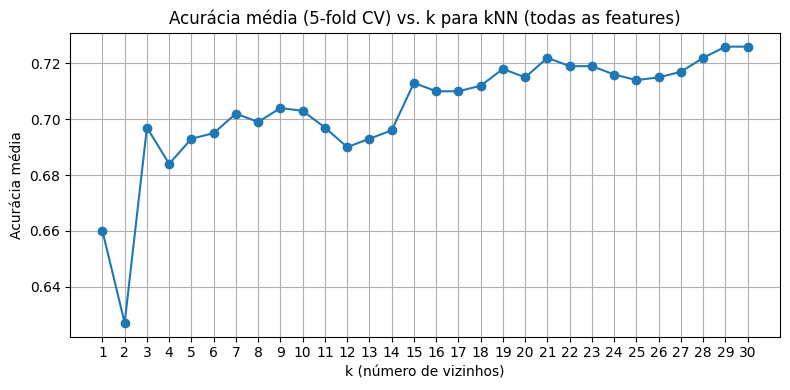

Melhor k via CV: 30


In [54]:
# Definir X_knn e y_knn
X_knn = X_pp.copy()
y_knn = y_final.copy()

# Normalização
scaler = MinMaxScaler()
X_knn_scaled = scaler.fit_transform(X_knn)

# Testar k de 1 a 30
k_values = range(1, 31)
cv_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn, X_knn_scaled, y_knn, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plotar curva acurácia vs k
plt.figure(figsize=(8, 4))
plt.plot(k_values, cv_scores, marker='o')
plt.title('Acurácia média (5-fold CV) vs. k para kNN (todas as features)')
plt.xlabel('k (número de vizinhos)')
plt.ylabel('Acurácia média')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()

# Escolher o melhor k
best_k = k_values[int(np.argmax(cv_scores))]
print(f"Melhor k via CV: {best_k}")

## Interpretação da Busca pelo Melhor k no kNN

* Acurácia média (5-fold CV) inicia em cerca de 66 % para **k = 1**, cai levemente em **k = 2**, e então sobe rapidamente.
* A partir de **k ≈ 5**, a acurácia se mantém acima de 69 %, mostrando que valores moderados de *k* já estabilizam o desempenho.
* No intervalo de 15 a 30 vizinhos, observa-se um ganho contínuo, atingindo o pico de **72,8 % em k = 30**.
* **Trade-off bias-variância:** Valores maiores de *k* reduzem a variância (menos sensibilidade a ruído), mas aumentam o enviesamento ao “suavizar” demais os limites de decisão. Aqui, porém, o viés extra parece ser compensado pela robustez trazida pelo grande número de vizinhos.

### Conclusão

O melhor valor de *k* encontrado foi **30**, que maximiza a acurácia média em validação cruzada. Usaremos esse parâmetro no treinamento final de kNN sobre o conjunto de teste.

---

## Treino Final e Avaliação no Conjunto de Teste

Com **k = 30** definido, vamos:

1.  Reaplicar o `MinMaxScaler` ajustando apenas em `X_train` e transformando `X_test`.
2.  Treinar o `KNeighborsClassifier` no treino e prever o teste.
3.  Calcular acurácia, precisão, recall, F1-score e exibir a matriz de confusão.

In [55]:
# 1) Reescalar treino e teste
scaler_final = MinMaxScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled  = scaler_final.transform(X_test)

# 2) Treinar kNN com k=best_k
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
knn_final.fit(X_train_scaled, y_train)

# 3) Prever e medir
y_pred_knn = knn_final.predict(X_test_scaled)

acc_knn  = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn)
rec_knn  = recall_score(y_test, y_pred_knn)
f1_knn   = f1_score(y_test, y_pred_knn)
cm_knn   = confusion_matrix(y_test, y_pred_knn)

print(f"kNN (k={best_k}) no teste:")
print(f"  Acurácia:  {acc_knn:.3f}")
print(f"  Precisão:  {prec_knn:.3f}")
print(f"  Recall:    {rec_knn:.3f}")
print(f"  F1-score:  {f1_knn:.3f}\n")
print("Matriz de Confusão kNN:")
print(cm_knn)

kNN (k=30) no teste:
  Acurácia:  0.750
  Precisão:  0.778
  Recall:    0.900
  F1-score:  0.834

Matriz de Confusão kNN:
[[ 24  36]
 [ 14 126]]


## Resultados do kNN (k=30) no Conjunto de Teste

* **Acurácia: 75,0 %**
    * O modelo acertou 75 de cada 100 clientes.
* **Precisão: 77,8 %**
    * Dos 162 clientes previstos como “good”, 126 realmente eram bons pagadores; 36 foram aprovados indevidamente (falsos positivos).
* **Recall: 90,0 %**
    * O kNN identificou 90 % dos verdadeiros bons pagadores, deixando apenas 14 falsos negativos.
* **F1-score: 83,4 %**
    * Indica um bom equilíbrio entre precisão e recall.

---

### Insights

* **Alto recall (90 %)** mostra que o kNN é muito eficaz em capturar bons pagadores, minimizando os falsos negativos.
* A **precisão de 77,8 %** ainda é razoável, embora o número de falsos positivos (36) indique clientes de risco aprovados.
* Em comparação com a Decision Tree, houve um ganho significativo no recall, apoiando cenários onde **retirar pequenos riscos** é menos crítico do que **não perder bons clientes**.